In [94]:
import theano as th
from theano import tensor as T
from numpy import random as rng
import numpy as np
from sklearn.base import BaseEstimator
from collections import OrderedDict
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

<h3>Define identify activation function</h3>

In [71]:
def identity(x):
    return x

<h2>Definition Autoencoder class</h2>

In [105]:
class AutoEncoder(BaseEstimator):

    def __init__(self,
                 input_size,
                 hidden_size = 6,
                 n_epochs=100,
                 mini_batch_size=20,
                 learning_rate=0.1,
                 K = 1.0):

        #Steepness parameter k for logistic function Sigmoid_ex
        self.K = K
        #Input_size is the same number of the input dimension, int.
        self.input_size = input_size
        #Hidden_size is the number of neurons in the hidden layer, int.
        self.hidden_size = hidden_size

        
        #Create random seed for randomly generate Weight matrix
        rng.seed(0)
        initial_W = np.asarray(rng.uniform(
                 low=-4 * np.sqrt(6. / (self.hidden_size + self.input_size)),
                 high=4 * np.sqrt(6. / (self.hidden_size + self.input_size)),
                 size=(self.input_size, self.hidden_size)), dtype=th.config.floatX)

        self.W = th.shared(value=initial_W, name='W', borrow=True)
        self.b1 = th.shared(name='b1', value=np.zeros(shape=(self.hidden_size,),
                            dtype=th.config.floatX),borrow=True)
        self.b2 = th.shared(name='b2', value=np.zeros(shape=(self.input_size,),
                            dtype=th.config.floatX),borrow=True)
        
        self.n_epochs = n_epochs
        self.mini_batch_size = mini_batch_size
        self.learning_rate = learning_rate
        
        
    
    #%% Sigmoid function with steepness parameter K
    def sigmoid_ex(self,x):
        return 1.0/(1.0 + T.exp(-self.K*x))
        #%% Fit data, define cost function and compute grad
        
        
    #Optimizing loss function    
    def fit(self, X):
        self.activation_function = self.sigmoid_ex   #hidden activation = sigmoid
        self.output_function = identity              #output activation = identity

        #X is an numpy matrix, rows and cols correspond to datapoints and features.
        #assert type(X) is np.ndarray
        assert len(X.shape)==2
        self.X = X                #Training set
        self.X = th.shared(name='X', value=np.asarray(self.X,
                         dtype=th.config.floatX),borrow=True)
        # Wrap data in theano variable which is to get this to run fast on the gpu.
        self.n = X.shape[1]    #Dimension
        self.m = X.shape[0]    #Size of data

        "****************** Compute hidden and output data *******************"
        index = T.lscalar()
        x=T.matrix('x')
        
        params = [self.W, self.b1, self.b2]  #List of parameters
        #Hidden data
        hidden = self.activation_function(T.dot(x, self.W)+self.b1)
        #Reconstruction data at output layer
        output = self.output_function(T.dot(hidden, T.transpose(self.W))+self.b2)

        "********************** Define cost function *************************"
        "Use cross-entropy loss, suitable for binary data"
        #L = -T.sum(x*T.log(output) + (1-x)*T.log(1-output), axis=1)
        #cost=T.mean(L)

        "MEAN-MSE is used in this work, for real-value data"
        cost = (((x - output)**2).mean(1)).mean()


        "*********** Update cost ******************"
        updates=[]
        #Return gradient with respect to W, b1, b2.
        gparams = T.grad(cost,params)

        "======ADAGRAD is used in this work ======="
        eps  = 1e-8
        accugrads = [th.shared(name='accugrad', value=np.zeros(shape=param.shape.eval(),
                            dtype=th.config.floatX),borrow=True) for param in params]
        # compute list of weights updates
        updates = OrderedDict()
        for accugrad, param, gparam in zip(accugrads, params, gparams):
            # c.f. Algorithm 1 in the Adadelta paper (Zeiler 2012)
            agrad = accugrad + gparam * gparam
            updates[param] = param - (self.learning_rate /(T.sqrt(agrad) + eps)) * gparam
            updates[accugrad] = agrad
        "==========================================="
        
        
        fit = th.function(inputs=[index],
                          outputs=[cost],
                          updates=updates,
                          givens={x:self.X[index:index+self.mini_batch_size,:]})
        
        re = 0  #reconstruction error after each epoch
        RE = [] #An array storing all re during training process
        for epoch in range(self.n_epochs):
            for row in range(0,self.m, self.mini_batch_size):
                re_batch = fit(row)
                re = re + re_batch[0]
                
            re = re/self.n_epochs   
            RE = np.append(RE, re)
            #print(re)
        RE = np.reshape(RE, (-1,1))    
        return RE
    
    
    #%% Get data from hidden layer
    def get_hidden(self,data):
        x=T.dmatrix('x')
        hidden = self.activation_function(T.dot(x,self.W)+self.b1)
        transformed_data = th.function(inputs=[x], outputs=[hidden])
        return transformed_data(data)
    
    
    
    #%% Get data from the output layer
    def get_output(self,data):
        x = T.dmatrix('x')
        hidden = self.activation_function(T.dot(x, self.W)+self.b1)
        output = self.output_function(T.dot(hidden,T.transpose(self.W))+self.b2)
        transformed_data = th.function(inputs = [x], outputs = [output])
        return transformed_data(data)
    
    
    
    #%% Get parameter values
    def get_weights(self):
        return [self.W.get_value(), self.b1.get_value(), self.b2.get_value()]

<h2>Load data</h2>

In [73]:
def process_Data(dataset):
    if (dataset == "WBC"):
        d = np.genfromtxt("data/wobc.csv", delimiter=",")
        label_threshold = 2
        # 9 attributes + 1 class[2 - benign(458); 4 - malignant(241)]
    elif (dataset == "WDBC"):
        d = np.genfromtxt("data/wdbc.csv", delimiter=",")
        label_threshold = 2
        # 30 attributes + 1 class [2 - benign(357); 4 - malignant(212)]
    elif (dataset == "C-heart"):
        d = np.genfromtxt("data/C-heart.csv", delimiter=",")
        label_threshold = 0
        # 13 attributes + 1 class [0 - Level0(164); level 1,2,3,4 - (139), 6 missing)
    elif (dataset == "ACA"):
        d = np.genfromtxt("data/australian.csv", delimiter=",")
        #Australia: 14 feature + 1 class [ 0 - 383, 1 - 307]
        label_threshold = 0
    else:
        print("No dataset is chosen")

    "*************************Chosing dataset*********************************"

    # discard the '?' values in wdbc
    d = d[~np.isnan(d).any(axis=1)]

    # shuffle
    np.random.seed(0)
    np.random.shuffle(d)

    dX = d[:,0:-1]      # discard the first column (ids) and the last (labels)
    dy = d[:,-1]

    dy = dy >label_threshold   # dataset 1-(2,4), 2-(2,4), 3-(0,1,2,3,4), 4-(0, 1)

    # separate into normal and anomaly
    dX0 = dX[~dy]   # Normal data
    dX1 = dX[dy]    # Anomaly data
    dy0 = dy[~dy]   # Normal label
    dy1 = dy[dy]    # Anomaly label

    split = 0.8    #split 70% for training and 30% for testing
    idx  = int(split * len(dX0))
    idx1 = int(split* len(dX1))
    # train_X contains only normal examples
    train_X = dX0[:idx]

    # test set is 30% of the normal class and 30% of anomaly class
    test_X = np.concatenate((dX0[idx:], dX1[idx1:]))  # 30% of normal and 30% anomal data
    test_y = np.concatenate((dy0[idx:], dy1[idx1:]))  # 30% of normal and 30% anomal labels

    print("Normal: %d, Test normal: %d, Test anomaly: %d" %(len(train_X), len(dX0)-len(train_X), len(dX1) - idx1))
    """We consider normal class and anomaly class are positive class and negative class
    espectively. Thus, we put true label equal 1 for normal and 0 for anomly examples
    in testing set. The roc_curve function will calculate FPR and TPR based on moving
    a threshold from high prediction values to low prediction values"""
    test_y = (~test_y).astype(np.int)

    return train_X, test_X, test_y

<H2>Plot RE curce</H2>

In [88]:
def Plotting_RE(RE, ymin, ymax):
    """Plotting RE during training process"""

    plt.figure(figsize=(6,3))
    plt.title('RE on training', fontsize=16)

    x = np.indices((len(RE),1))
    
    plt.xlim([0.0, len(RE) + 1.0])
    plt.ylim([ymin,ymax])

    plt.plot(x[0], RE,  'b', label = 'Recon error')
    plt.legend(loc='upper right')
    plt.ylabel('RE', fontsize=14)
    plt.xlabel('Epochs', fontsize=14)
    plt.show()

<h2>Training Autoencode</h2>

Normal: 355, Test normal: 89, Test anomaly: 48
[[ 0.47547411  0.43118054  0.40241388  0.38106091  0.3638887   0.34947302
   0.33703866  0.3261088   0.31636604  0.30758698  0.29960766  0.29230381
   0.28557873  0.27935555  0.27357203  0.26817695  0.2631276   0.25838788
   0.25392701  0.24971845  0.24573917  0.24196903  0.23839034  0.23498746
   0.23174652  0.22865515  0.22570232  0.2228781   0.22017359  0.21758072
   0.21509221  0.21270144  0.21040238  0.20818954  0.20605786  0.20400274
   0.20201993  0.2001055   0.19825585  0.19646763  0.19473774  0.19306329
   0.1914416   0.18987016  0.18834665  0.18686888  0.18543481  0.18404252
   0.1826902   0.18137617  0.18009882  0.17885667  0.17764828  0.17647232
   0.17532753  0.1742127   0.17312669  0.17206844  0.17103692  0.17003116
   0.16905023  0.16809326  0.1671594   0.16624787  0.16535789  0.16448875
   0.16363975  0.16281024  0.16199956  0.16120713  0.16043236  0.1596747
   0.15893361  0.15820858  0.15749912  0.15680477  0.15612507  0.1

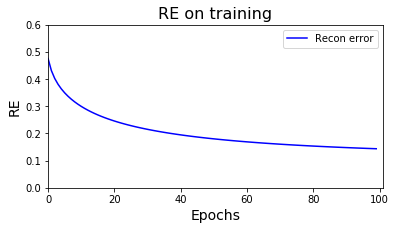

In [92]:
train_X, test_X, test_y = process_Data("WBC")     

#Normalize data using standard scaler
scaler = preprocessing.StandardScaler()
scaler.fit(train_X)
train_X_scale = scaler.transform(train_X)
test_X_scale  = scaler.transform(test_X)


input_size  = train_X_scale.shape[1]
h_size      = (np.sqrt(input_size)).astype(np.int) + 1
epoch       = 100
l_rate      = 0.01
k           = 1.0 


#create an AE object
AE = AutoEncoder(input_size          = input_size,
                     hidden_size     = h_size,
                     n_epochs        = epoch,
                     learning_rate   = l_rate,
                     K               = k)


RE = AE.fit(train_X_scale)
print(np.reshape(RE, (1,-1)))
Plotting_RE(re, 0, 0.6)

<h2>BUild RE-based classifier</h2>

In [98]:
#get reconstruction of train_X and test_X
output_train  = AE.get_output(train_X_scale)
output_test   = AE.get_output(test_X_scale)


#*************** RE on each example *************"
RE_MSE = (((test_X - output_test[0])**2).mean(1))

"""RE (MSE) between output and input is used as anomalous score.
We put minus "-" to RE_MSE to for computing FPR and TPR using roc_curve"""

predictions_auto = -RE_MSE
FPR_ae, TPR_ae, thresholds_auto = roc_curve(actual, predictions_auto)
auc_ae = auc(FPR_ae, TPR_ae)
print('AUC: %0.3f' %auc_ae)

AUC: 0.993


<h2>View hidden data</h2>

In [103]:
#get hidden data of train_X and test_X
train_z  = AE.get_hidden(train_X_scale)
test_z   = AE.get_hidden(test_X_scale)

train_z

[array([[  9.97471694e-01,   6.31840466e-01,   2.27169507e-01,
           4.39930227e-01],
        [  1.05567409e-01,   1.81869694e-01,   5.98294382e-01,
           1.36315074e-01],
        [  3.15864019e-01,   5.50997146e-02,   7.45718965e-01,
           2.72828647e-02],
        ..., 
        [  8.22807772e-01,   1.73545157e-01,   9.68849142e-01,
           4.15882249e-02],
        [  3.28515508e-01,   7.22174854e-02,   8.12727617e-02,
           9.99998838e-01],
        [  6.43735239e-01,   9.83542410e-01,   2.26634330e-01,
           9.28505195e-04]])]